# Emotion Classification
## DATASCI 281 - Computer Vision
### Students: Diego Moss, Subhasis Das, Priscilla Miller

## Import Libraries/Modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
import utils
import preprocessing_functions as pf
from skimage.filters import gabor
import cv2
from skimage.feature import hog
import time

## Feature Extraction Functions

In [2]:
# feature extraction functions
# extract sobel edge
def sobel_edges(images_array):
    images_array = feature_preprocessing(images_array, norm=False, gray=True, contrast=False)
    n_images = images_array.shape[0]
    processed = np.zeros(images_array.shape[:3], dtype=np.uint8)
    for i in range(n_images):
        # histogram equalization
        img_eq = cv2.equalizeHist(images_array[i])
        
        # Apply Sobel edge detection
        # Sobel in X direction
        sobelx = cv2.Sobel(img_eq, cv2.CV_64F, 1, 0, ksize=5)
        # Sobel in Y direction
        sobely = cv2.Sobel(img_eq, cv2.CV_64F, 0, 1, ksize=5)
        # Combine both gradients
        sobel_combined = cv2.magnitude(sobelx, sobely)
        processed[i] = sobel_combined
    processed = processed.reshape(processed.shape[0], -1)
    return processed

# extract gabor
def compute_gabor(images, params={"theta": 90, "frequency": 0.2, "sigma": 2, "bandwidth": 0.5, "offset": np.pi}):
    
    images = feature_preprocessing(images, norm=False, gray=True, contrast=False)
    
    n_images = len(images)
    gabor_features = []
    
    for i in range(n_images):
        # Get current image
        image = images[i]

        # Apply Gabor filter
        response, gabor_image = gabor(image, 
                           frequency=params["frequency"], 
                           theta=np.deg2rad(params["theta"]),
                           sigma_x=params["sigma"], 
                           sigma_y=params["sigma"],
                           bandwidth=params["bandwidth"], 
                           offset=params["offset"])
        
        # Store features
        gabor_features.append(response.flatten())
    
    return np.array(gabor_features), gabor_image

# extract HOG
def extract_hog_features(images, orientations=18, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', channel=None):
    
    images = feature_preprocessing(images, norm=False, gray=True, contrast=False)
    
    n_samples = len(images)
    
    # Process first image to get feature dimensions
    fd = hog(images[0], 
             orientations=orientations,
             pixels_per_cell=pixels_per_cell,
             cells_per_block=cells_per_block,
             block_norm=block_norm,
             feature_vector=True,
             channel_axis=channel)
    
    # Initialize feature array
    features = np.zeros((n_samples, len(fd)))
    features[0] = fd
    
    # Process remaining images
    for i in range(1, n_samples):
        features[i] = hog(images[i],
                         orientations=orientations,
                         pixels_per_cell=pixels_per_cell,
                         cells_per_block=cells_per_block,
                         block_norm=block_norm,
                         feature_vector=True,
                         channel_axis=channel)
    
    return features

# Preprocessing function 
def feature_preprocessing(images, norm=False, gray=False, contrast=False):
    preprocessed_images = images
    if norm:
        preprocessed_images = pf.normalize_images(preprocessed_images)
    if gray:
        preprocessed_images = pf.convert_to_grayscale(preprocessed_images)
    if contrast:
        preprocessed_images = pf.apply_contrast_normalization(preprocessed_images)
    return preprocessed_images

## PCA Functions

In [3]:
# combine feature vectors and apply PCA function
def combine_and_run_pca(*feature_vectors, n_components=None):

    if len(feature_vectors) == 0:
        raise ValueError("At least one feature vector must be provided")
    
    # Ensure all inputs are numpy arrays
    feature_vectors = [np.asarray(fv) for fv in feature_vectors]
    
    # Check if all feature vectors have the same number of samples
    n_samples = feature_vectors[0].shape[0]
    for i, fv in enumerate(feature_vectors):
        if fv.shape[0] != n_samples:
            raise ValueError(f"Feature vector {i} has {fv.shape[0]} samples, but {n_samples} were expected")
    
    # Concatenate the feature vectors along the feature axis
    combined_features = np.hstack(feature_vectors)
    print(f"Combined feature shape: {combined_features.shape}")
    
    # Calculate total feature dimensions
    total_dims = sum(fv.shape[1] for fv in feature_vectors)
    print(f"Feature dimensions: {[fv.shape[1] for fv in feature_vectors]}, total: {total_dims}")
    
    # Initialize and fit PCA
    if n_components is None:
        n_components = min(combined_features.shape)
    
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(combined_features)
    
    return pca, transformed_data


# Plot explained variance
def plot_pca_explained_variance(pca, save_path=None, show_plot=True, figsize=(10, 6), dpi=300, features=None):

    fig, ax = plt.subplots(figsize=figsize)
    
    if features is not None:
        feature_string = " + ".join(str(x) for x in features)
        feature_string = " (" + feature_string + ")"
    else:
        feature_string = ""
        
    # Plot the cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
            linestyle='-', label=f'Cumulative Variance{feature_string}')
    
    # Plot the explained variance for each component
    ax.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
          pca.explained_variance_ratio_, alpha=0.5, 
          label='Individual Explained Variance')
    
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Explained Variance')
    ax.set_title('PCA Explained Variance by Components')
    ax.legend(loc='lower right')
    ax.grid(True)
    
    # Add horizontal lines at common thresholds
    thresholds = [0.9, 0.95, 0.99]
    colors = ['r', 'g', 'b']

    for threshold, color in zip(thresholds, colors):
        ax.axhline(y=threshold, color=color, linestyle='-', alpha=0.3)

        # Find component number for this threshold
        if any(cumulative_variance >= threshold):
            components_needed = np.argmax(cumulative_variance >= threshold) + 1
            ax.annotate(f'{components_needed} components for {threshold*100}%',
                        xy=(components_needed, threshold),
                        xytext=(components_needed + 1, threshold + 0.02),
                        arrowprops=dict(arrowstyle='->'),
                        fontsize=9)
    
    plt.tight_layout()
    
    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi)
    
    # Show the plot if requested
    if show_plot:
        plt.show()
    else:
        plt.close()
        
    return fig, ax


# remove components function
def remove_pca_components(pca_model, transformed_data, method='threshold', value=0.95):

    cumulative_variance = np.cumsum(pca_model.explained_variance_ratio_)
    
    if method == 'threshold':
        if not (0 < value <= 1):
            raise ValueError("Threshold value must be between 0 and 1")
        
        # Find how many components we need to reach the variance threshold
        if any(cumulative_variance >= value):
            n_components = np.argmax(cumulative_variance >= value) + 1
            variance_explained = cumulative_variance[n_components-1]
        else:
            n_components = len(pca_model.explained_variance_ratio_)
            variance_explained = cumulative_variance[-1]
            print(f"Warning: Cannot reach {value*100:.1f}% variance threshold. Using all {n_components} components.")
        
    elif method == 'components':
        value = int(value)
        if not (0 < value <= transformed_data.shape[1]):
            raise ValueError(f"Number of components must be between 1 and {transformed_data.shape[1]}")
        
        n_components = value
        variance_explained = cumulative_variance[n_components-1] if n_components <= len(cumulative_variance) else 1.0
        
    else:
        raise ValueError("Method must be 'threshold' or 'components'")
    
    # Extract only the required components
    reduced_data = transformed_data[:, :n_components]
    
    print(f"Selected {n_components} out of {transformed_data.shape[1]} components")
    print(f"Variance explained: {variance_explained:.4f} ({variance_explained*100:.2f}%)")
    print(f"Reduced data shape: {reduced_data.shape}")
    
    return reduced_data, n_components, variance_explained



## Load Dataset

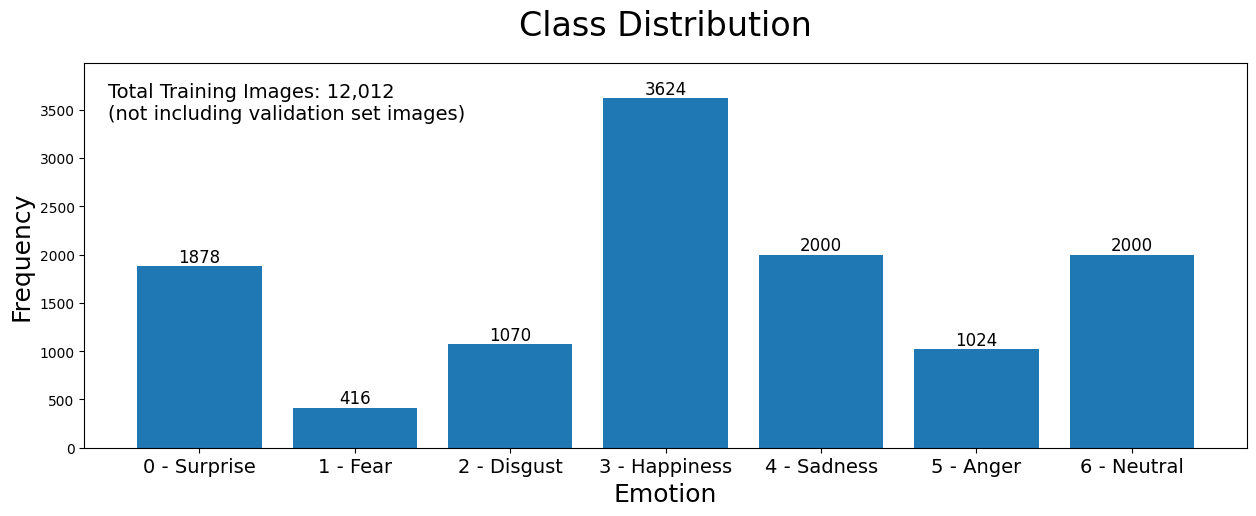

In [4]:
# load shuffled and denoised images
train_images, train_labels, val_images, val_labels, test_images, test_labels = utils.load_processed_data('all_augmented_preprocessed_data.pkl')

# label mapping
labels_dict = {0: 'surprise', 1: 'fear', 2: 'disgust', 3: 'happiness', 4: 'sadness', 5: 'anger', 6: 'neutral'}

# Adjust label values to be from 0 to 6
y_train = train_labels - 1
y_val = val_labels - 1
y_test = test_labels - 1

# Visualize distribution of training images
# Find unique value counts
unique, counts = np.unique(y_train, return_counts=True)
classes = [str(num) + " - " + labels_dict[num].title() for num in unique]
total_count = sum(counts)

# Create plot
plt.figure(figsize=(15, 5))
bars = plt.bar(range(len(counts)), counts)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Label/title plot
plt.title("Class Distribution", fontsize=24, y=1.05)
plt.xlabel("Emotion", fontsize=18)
plt.xticks(np.arange(len(counts)), classes, fontsize=14)
plt.ylabel("Frequency", fontsize=18)
plt.ylim(0, max(counts) * 1.1)
# Add total count as text annotation in upper right
plt.text(0.02, 0.95, f'Total Training Images: {total_count:,}\n(not including validation set images)', 
         transform=plt.gca().transAxes,
         ha='left', va='top',
         fontsize=14)

# Render plot
plt.show()

## Extract Features

In [5]:
# extract features
# training set
hog_features = extract_hog_features(train_images, channel=None)
gabor_features, _ = compute_gabor(train_images)
edge_features = sobel_edges(train_images)

# validation set
hog_features_val = extract_hog_features(val_images, channel=None)
gabor_features_val, _ = compute_gabor(val_images)
edge_features_val = sobel_edges(val_images)

# test set
hog_features_test = extract_hog_features(test_images, channel=None)
gabor_features_test, _ = compute_gabor(test_images)
edge_features_test = sobel_edges(test_images)

# normalize
gabor_features = gabor_features/255
edge_features = edge_features/255

gabor_features_val = gabor_features_val/255
edge_features_val = edge_features_val/255

gabor_features_test = gabor_features_test/255
edge_features_test = edge_features_test/255


### ResNet

In [6]:
# Normalize

resnet_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [C, H, W] and scales to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

def preprocess_array(img_array):
    if img_array.ndim == 2:  # Grayscale
        img_array = np.stack([img_array]*3, axis=-1)  # Convert to RGB
    img_array = img_array.astype(np.uint8)  # Make sure it's uint8 before ToTensor
    img_tensor = resnet_transform(img_array)  # Applies ToTensor and Normalize
    return img_tensor


if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Load ResNet and remove the classifier layer
weights = ResNet18_Weights.DEFAULT
resnet = resnet18(weights=weights)
resnet_extractor = nn.Sequential(*list(resnet.children())[:-1]).to(device)
resnet_extractor.eval()

def extract_features_batch(images):
    features = []
    with torch.no_grad():
        for img in images:
            x = preprocess_array(img).unsqueeze(0).to(device)  # (1, 3, H, W)
            feat = resnet_extractor(x).view(-1).cpu().numpy()  # (512,)
            features.append(feat)
    return np.stack(features)

resnet_feats = extract_features_batch(train_images)
resnet_val_feats = extract_features_batch(val_images)
resnet_test_feats = extract_features_batch(test_images)

## Run PCA and Remove Components

Combined feature shape: (12012, 29224)
Feature dimensions: [8712, 10000, 10000, 512], total: 29224
Transformed data shape: (12012, 12012)


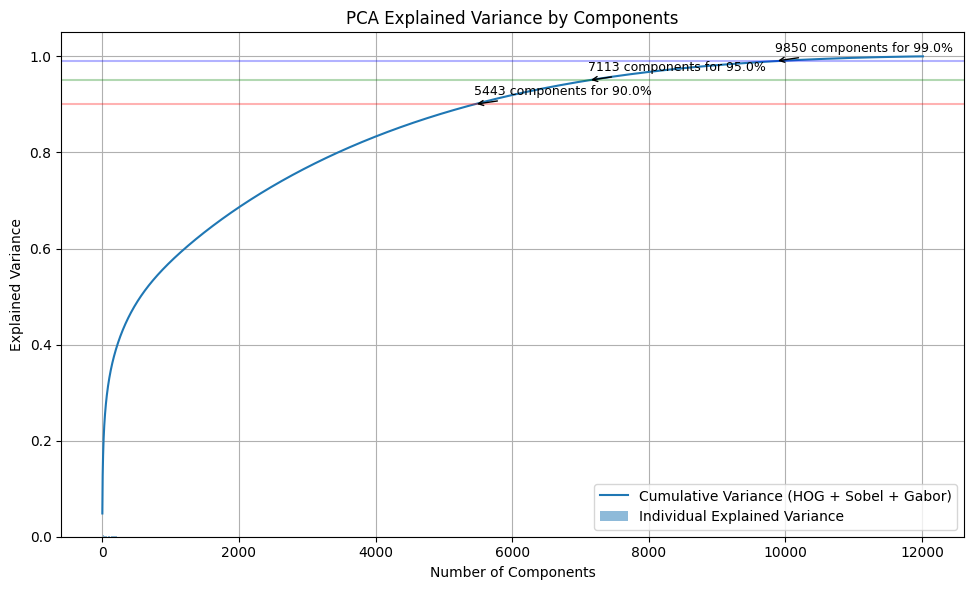

Selected 7113 out of 12012 components
Variance explained: 0.9500 (95.00%)
Reduced data shape: (12012, 7113)
Selected 7113 out of 12012 components
Variance explained: 0.9500 (95.00%)
Reduced data shape: (3068, 7113)
Selected 7113 out of 12012 components
Variance explained: 0.9500 (95.00%)
Reduced data shape: (3068, 7113)


In [7]:
# Run PCA on combined features
pca_model, transformed_data = combine_and_run_pca(
    hog_features,
    edge_features,
    gabor_features,
    resnet_feats
)

print(f"Transformed data shape: {transformed_data.shape}")
# Plot the explained variance
plot_pca_explained_variance(pca_model, save_path='pca_explained_variance.png', features=["HOG", "Sobel", "Gabor"]);

# remove unnecessary components 
threshold = 0.95
X_train, n_components, variance = remove_pca_components(
    pca_model, transformed_data, method='threshold', value=threshold
)

# Transform validation data using the existing PCA model
val_pca_transformed = pca_model.transform(np.hstack([
    hog_features_val,
    edge_features_val,
    gabor_features_val,
    resnet_val_feats
]))

X_val, _, _ = remove_pca_components(
    pca_model, 
    val_pca_transformed, 
    method='threshold',  
    value=threshold           
)

# Transform test data using the existing PCA model
test_pca_transformed = pca_model.transform(np.hstack([
    hog_features_test,
    edge_features_test,
    gabor_features_test,
    resnet_test_feats]))

X_test, _, _ = remove_pca_components(
    pca_model, 
    test_pca_transformed, 
    method='threshold',  
    value=threshold          
)

## t-SNE

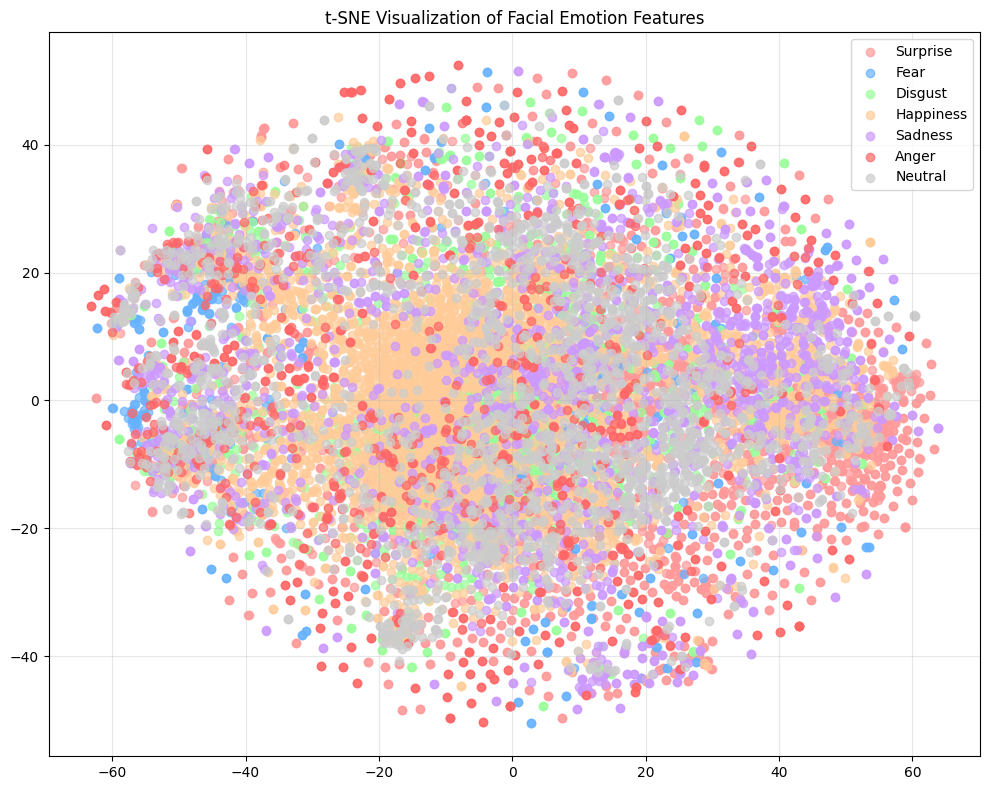

In [8]:
# tsne
# Apply t-SNE to the PCA-reduced features
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
features_tsne = tsne.fit_transform(X_train)

# Create scatter plot
plt.figure(figsize=(10, 8))
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#CC99FF', '#FF6666', '#CCCCCC']

# Map each label in your dictionary to a color
for i, (label_num, emotion) in enumerate(labels_dict.items()):
    # Plot points for this emotion
    idx = np.where(y_train == label_num)[0]
    plt.scatter(features_tsne[idx, 0], features_tsne[idx, 1], 
                c=colors[i % len(colors)], label=emotion.capitalize(), alpha=0.7)

plt.title('t-SNE Visualization of Facial Emotion Features')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('tsne_emotion_features.png', dpi=300)
plt.show()

## Check Shapes and Get Class Weights

In [9]:
# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of val labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

# Calculate class weights to correct for class imbalance
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))


Shape of train images  (12012, 7113)
Shape of train labels  (12012,)
Shape of val images  (3068, 7113)
Shape of val labels  (3068,)
Shape of test images  (3068, 7113)
Shape of test labels  (3068,)


## Create Validation Subsets for Hyperparameters Search

In [10]:
# Create validation subsets for hyperparameter search
def create_val_subsets(val_x, val_y, n_subsets=3):
    val_x, val_y = shuffle(val_x, val_y, random_state=1234)
    subset_size = len(val_x) // n_subsets
    return [(val_x[d*subset_size:(d+1)*subset_size], val_y[d*subset_size:(d+1)*subset_size])
            for d in range(n_subsets)]

val_subsets = create_val_subsets(X_val, y_val, n_subsets=3)

## Perception Model

In [11]:
# Set seeds
torch.manual_seed(1234)
np.random.seed(1234)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS backend on Apple Silicon")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

# Class weights (optional)
weight_list = [class_weights[i] for i in range(len(class_weights))]
class_weights_tensor = torch.tensor(weight_list, dtype=torch.float32).to(device)

def build_model(input_dim, hidden_units, dropout_rate):
    layers = []
    prev_units = input_dim
    for units in hidden_units:
        layers.append(nn.Linear(prev_units, units))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(units))
        layers.append(nn.Dropout(dropout_rate))
        prev_units = units
    layers.append(nn.Linear(prev_units, 7))  # output logits for 7 classes
    return nn.Sequential(*layers)

def train_one_model(model, train_loader, val_loader, learning_rate, weight_decay, class_weights, epochs=10, patience=3):
    model.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    best_val_loss = float('inf')
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        val_loss, val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{epochs} "
              f"| Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
              f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered due to no val loss improvement.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)
    return best_val_loss, best_val_acc


def evaluate_model(model, loader):
    model.eval()
    correct, total, total_loss = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            total_loss += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return total_loss / total, correct / total


Using MPS backend on Apple Silicon


### Baseline (Perceptron)

In [12]:
baseline_model = build_model(input_dim=X_train.shape[1], hidden_units=[32], dropout_rate=0.1)

baseline_val_loss, baseline_val_acc = train_one_model(
    baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=0.01,
    weight_decay=0.0,
    class_weights=class_weights_tensor,
    epochs=10
)

print(f"\nBaseline validation accuracy: {baseline_val_acc:.2%}")
print(f"Baseline validation loss: {baseline_val_loss:.4f}")

Epoch 1/10 | Train Loss: 1.3658 | Train Acc: 0.5082 | Val Loss: 1.1021 | Val Acc: 0.6046
Epoch 2/10 | Train Loss: 0.3959 | Train Acc: 0.8646 | Val Loss: 1.3799 | Val Acc: 0.5926
Epoch 3/10 | Train Loss: 0.1275 | Train Acc: 0.9563 | Val Loss: 1.6365 | Val Acc: 0.6007
Epoch 4/10 | Train Loss: 0.0775 | Train Acc: 0.9720 | Val Loss: 1.9019 | Val Acc: 0.6027
Early stopping triggered due to no val loss improvement.

Baseline validation accuracy: 60.46%
Baseline validation loss: 1.1021


### Multi-Layer Perceptron

#### Hyperparameter Search

In [13]:
param_dist = {
    'learning_rate': [1e-3, 1e-4],
    'dropout_rate': [0.3, 0.5],
    'l2_reg': [0.001, 0.01],
    'hidden_units': [(32,), (64, 32)]
}
param_list = list(ParameterSampler(param_dist, n_iter=16, random_state=1234))

best_score_acc = -np.inf
best_score_loss = float('inf')
best_params = None

for params in param_list:
    print(f"\nTesting: {params}")
    model = build_model(
        input_dim=X_train.shape[1],
        hidden_units=params['hidden_units'],
        dropout_rate=params['dropout_rate']
    )
    best_val_loss, best_val_acc = train_one_model(
        model,
        train_loader=train_loader,
        val_loader=val_loader,
        learning_rate=params['learning_rate'],
        weight_decay=params['l2_reg'],
        class_weights=class_weights_tensor,
        epochs=30
    )
    print(f"Best Val Loss: {best_val_loss:.4f} | Best Val Accuracy: {best_val_acc:.4f}")

    if (best_val_acc > best_score_acc) or \
       (best_val_acc == best_score_acc and best_val_loss < best_score_loss):
        best_score_acc = best_val_acc
        best_score_loss = best_val_loss
        best_params = params

print(f"\nBest validation accuracy: {best_score_acc:.4f}")
print(f"Corresponding validation loss: {best_score_loss:.4f}")
print(f"Best hyperparameters: {best_params}")



Testing: {'learning_rate': 0.001, 'l2_reg': 0.001, 'hidden_units': (32,), 'dropout_rate': 0.3}
Epoch 1/30 | Train Loss: 1.5124 | Train Acc: 0.4321 | Val Loss: 1.1505 | Val Acc: 0.6151
Epoch 2/30 | Train Loss: 0.6708 | Train Acc: 0.8107 | Val Loss: 1.0533 | Val Acc: 0.6323
Epoch 3/30 | Train Loss: 0.3245 | Train Acc: 0.9135 | Val Loss: 1.0886 | Val Acc: 0.6301
Epoch 4/30 | Train Loss: 0.1871 | Train Acc: 0.9572 | Val Loss: 1.1510 | Val Acc: 0.6183
Epoch 5/30 | Train Loss: 0.1290 | Train Acc: 0.9703 | Val Loss: 1.2274 | Val Acc: 0.6252
Early stopping triggered due to no val loss improvement.
Best Val Loss: 1.0533 | Best Val Accuracy: 0.6323

Testing: {'learning_rate': 0.0001, 'l2_reg': 0.001, 'hidden_units': (32,), 'dropout_rate': 0.3}
Epoch 1/30 | Train Loss: 1.9635 | Train Acc: 0.2133 | Val Loss: 1.7173 | Val Acc: 0.3530
Epoch 2/30 | Train Loss: 1.4476 | Train Acc: 0.4607 | Val Loss: 1.5146 | Val Acc: 0.4902
Epoch 3/30 | Train Loss: 1.1559 | Train Acc: 0.6363 | Val Loss: 1.3801 | Val 

#### MLP Model Using Best Params

In [14]:
mlp_model = build_model(
    input_dim=X_train.shape[1],
    hidden_units=best_params['hidden_units'],
    dropout_rate=best_params['dropout_rate']
)

start_time = time.time()

# Retrain on full training set
final_val_loss, final_val_acc = train_one_model(
    mlp_model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=best_params['learning_rate'],
    weight_decay=best_params['l2_reg'],
    class_weights=class_weights_tensor,
    epochs=30
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")


# Evaluate on test set
test_loss, test_acc = evaluate_model(mlp_model, test_loader)
print(f"\nFinal model validation accuracy: {final_val_acc:.2%}")
print(f"Final model test accuracy: {test_acc:.2%}")


Epoch 1/30 | Train Loss: 2.1361 | Train Acc: 0.1627 | Val Loss: 1.9303 | Val Acc: 0.1741
Epoch 2/30 | Train Loss: 1.8750 | Train Acc: 0.2428 | Val Loss: 1.8243 | Val Acc: 0.2314
Epoch 3/30 | Train Loss: 1.7302 | Train Acc: 0.2950 | Val Loss: 1.7365 | Val Acc: 0.3093
Epoch 4/30 | Train Loss: 1.6073 | Train Acc: 0.3610 | Val Loss: 1.6548 | Val Acc: 0.3579
Epoch 5/30 | Train Loss: 1.4743 | Train Acc: 0.4267 | Val Loss: 1.5695 | Val Acc: 0.4126
Epoch 6/30 | Train Loss: 1.3787 | Train Acc: 0.4758 | Val Loss: 1.5186 | Val Acc: 0.4423
Epoch 7/30 | Train Loss: 1.2803 | Train Acc: 0.5310 | Val Loss: 1.4159 | Val Acc: 0.5026
Epoch 8/30 | Train Loss: 1.1984 | Train Acc: 0.5672 | Val Loss: 1.3916 | Val Acc: 0.5147
Epoch 9/30 | Train Loss: 1.0959 | Train Acc: 0.6206 | Val Loss: 1.3293 | Val Acc: 0.5404
Epoch 10/30 | Train Loss: 1.0179 | Train Acc: 0.6654 | Val Loss: 1.2694 | Val Acc: 0.5616
Epoch 11/30 | Train Loss: 0.9224 | Train Acc: 0.7128 | Val Loss: 1.2344 | Val Acc: 0.5769
Epoch 12/30 | Train

<Figure size 800x600 with 0 Axes>

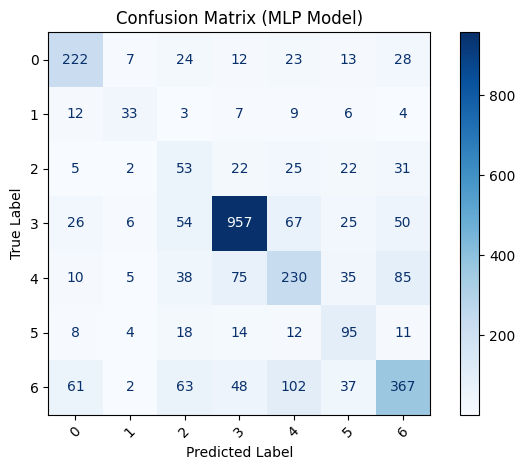

In [15]:
# Predict on test set
mlp_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        outputs = mlp_model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())

y_test_pred = np.array(all_preds)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.get_cmap('Blues'), xticks_rotation=45)
plt.title("Confusion Matrix (MLP Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()


#### ROC Curve for MLP Model

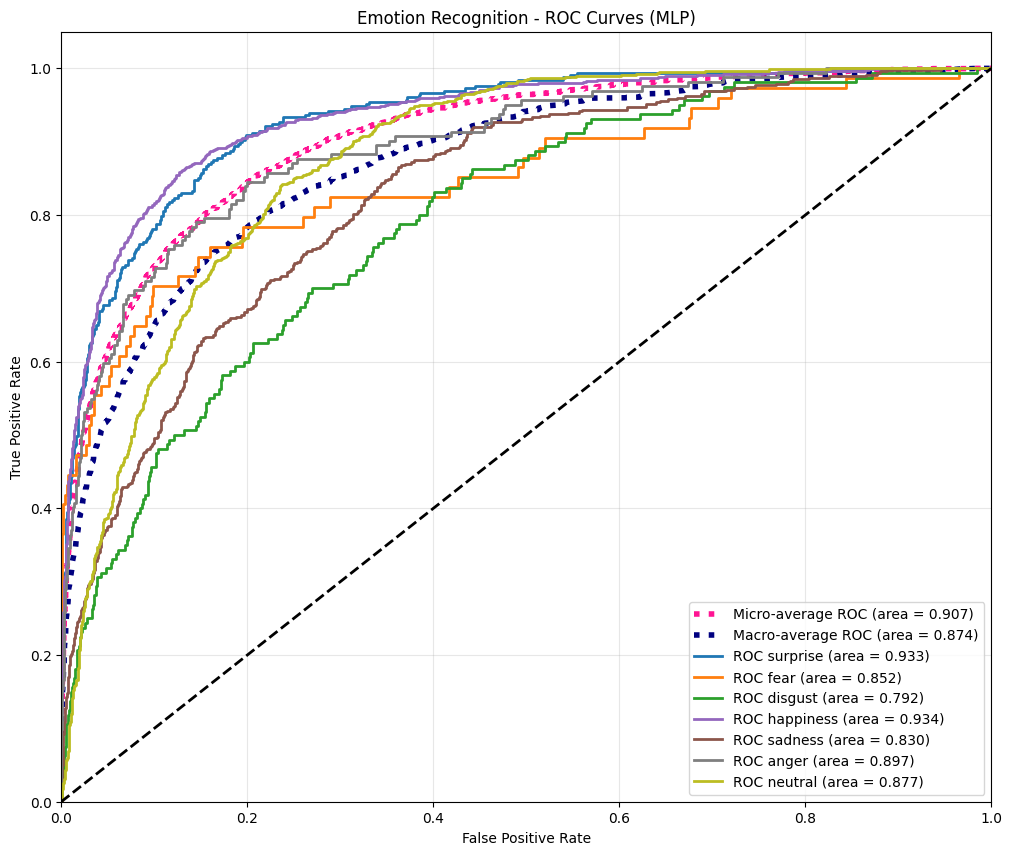

One-vs-Rest AUC scores:
surprise: 0.9327
fear: 0.8523
disgust: 0.7923
happiness: 0.9339
sadness: 0.8296
anger: 0.8965
neutral: 0.8767
Micro-average AUC: 0.9067
Macro-average AUC: 0.8737


In [16]:
# Set model to eval mode
mlp_model.eval()

# Get softmax probabilities on test set
y_test_probs = []
y_test_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = mlp_model(xb)
        probs = F.softmax(outputs, dim=1)  # Get predicted probabilities
        y_test_probs.append(probs.cpu().numpy())
        y_test_true.append(yb.cpu().numpy())

# Stack all batches
y_test_proba_mlp = np.vstack(y_test_probs)
y_test = np.concatenate(y_test_true)

# Binarize labels
n_classes = y_test_proba_mlp.shape[1]
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Compute FPR, TPR, and AUC
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba_mlp[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_test_proba_mlp.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot
plt.figure(figsize=(12, 10))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC (area = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC (area = {roc_auc["macro"]:.3f})',
         color='navy', linestyle=':', linewidth=4)

cmap = plt.get_cmap('tab10')
for i in range(n_classes):
    color = cmap(i / n_classes)
    emotion_label = labels_dict[i]  # Assuming i maps to label
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {emotion_label} (area = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Emotion Recognition - ROC Curves (MLP)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Print AUCs
print("One-vs-Rest AUC scores:")
for i in range(n_classes):
    emotion_label = labels_dict[i]
    print(f"{emotion_label}: {roc_auc[i]:.4f}")

print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")


## Logistic Regression

In [20]:
# Logistic Regression with 
# Define hyperparameter grid
C_values = [0.01, 0.1, 1]

best_score = -np.inf
best_params = None

# Manual grid search over 'C'
for C in C_values:
    print(f"\nTesting C = {C}")
    scores = []

    # Train on training set, evaluate on each val subset
    model = LogisticRegression(C=C, max_iter=5000, solver='sag', class_weight=class_weights)

    model.fit(X_train, y_train)

    for X_val_sub, y_val_sub in val_subsets:
        y_pred = model.predict(X_val_sub)
        acc = accuracy_score(y_val_sub, y_pred)
        scores.append(acc)

    avg_score = np.mean(scores)
    print(f"Average val accuracy: {avg_score:.4f}")

    if avg_score > best_score:
        best_score = avg_score
        best_params = {'C': C}

# Final model training on full training set with best C
print(f"\nBest hyperparameters: {best_params}, accuracy: {best_score:.4f}")
lr = LogisticRegression(C=best_params['C'], max_iter=1000, solver='sag', class_weight=class_weights)


start_time = time.time()

lr.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")


# Evaluate on validation and test sets
y_val_pred_lr = lr.predict(X_val)
y_test_pred_lr = lr.predict(X_test)

print("\nLogistic Regression Report (Validation):")
print(classification_report(y_val, y_val_pred_lr))

print("\nLogistic Regression Report (Test):")
print(classification_report(y_test, y_test_pred_lr))


Testing C = 0.01
Average val accuracy: 0.6761

Testing C = 0.1
Average val accuracy: 0.6696

Testing C = 1
Average val accuracy: 0.6644

Best hyperparameters: {'C': 0.01}, accuracy: 0.6761
Training time: 155.05 seconds

Logistic Regression Report (Validation):
              precision    recall  f1-score   support

           0       0.66      0.70      0.67       351
           1       0.47      0.34      0.40        73
           2       0.30      0.34      0.32       182
           3       0.85      0.84      0.85      1148
           4       0.58      0.58      0.58       478
           5       0.57      0.53      0.55       193
           6       0.62      0.62      0.62       643

    accuracy                           0.68      3068
   macro avg       0.58      0.56      0.57      3068
weighted avg       0.68      0.68      0.68      3068


Logistic Regression Report (Test):
              precision    recall  f1-score   support

           0       0.66      0.72      0.69       

<Figure size 800x600 with 0 Axes>

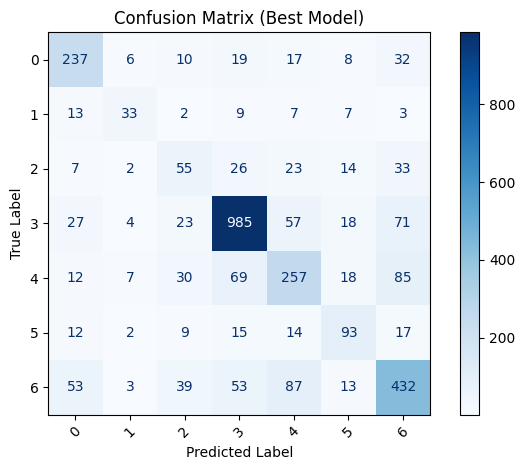

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.get_cmap('Blues'), xticks_rotation=45)
plt.title("Confusion Matrix (Best Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()

## ROC Curve for Logistic Regression Model

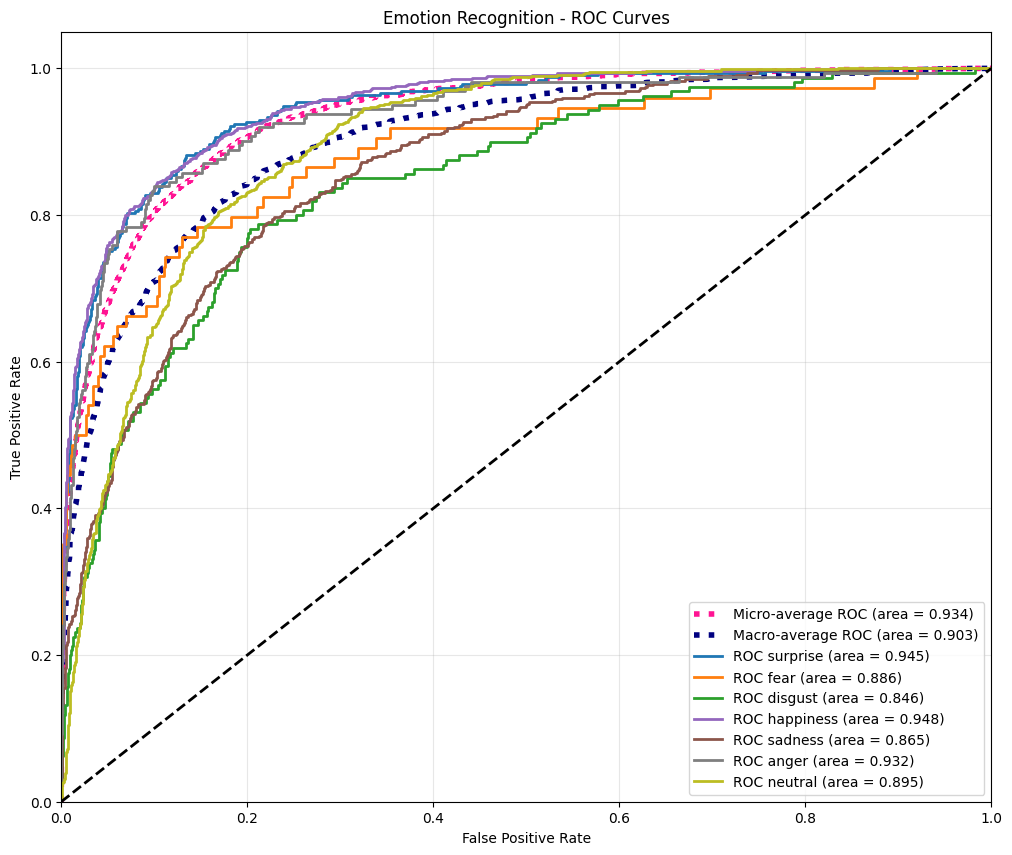

One-vs-Rest AUC scores:
surprise: 0.9446
fear: 0.8857
disgust: 0.8463
happiness: 0.9477
sadness: 0.8647
anger: 0.9324
neutral: 0.8955
Micro-average AUC: 0.9345
Macro-average AUC: 0.9027


In [22]:
# Get probability predictions
y_val_proba_lr = lr.predict_proba(X_val)
y_test_proba_lr = lr.predict_proba(X_test)

# Get the number of classes
n_classes = len(lr.classes_)

# Binarize the labels for one-vs-rest approach
y_val_bin = label_binarize(y_val, classes=lr.classes_)
y_test_bin = label_binarize(y_test, classes=lr.classes_)

# Initialize dictionaries to store FPR, TPR, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba_lr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_test_proba_lr.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 10))

# Plot micro-average and macro-average ROC curves
plt.plot(fpr["micro"], tpr["micro"], 
         label=f'Micro-average ROC (area = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (area = {roc_auc["macro"]:.3f})',
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curves for each class
# Get color values from the colormap
cmap = plt.get_cmap('tab10')
for i in range(n_classes):
    color = cmap(i / n_classes)  # Get color from colormap
    # Use emotion label from dictionary instead of numeric class
    emotion_label = labels_dict[lr.classes_[i]]
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {emotion_label} (area = {roc_auc[i]:.3f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Emotion Recognition - ROC Curves')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Print AUC scores for OvR approach with emotion labels
print("One-vs-Rest AUC scores:")
for i in range(n_classes):
    emotion_label = labels_dict[lr.classes_[i]]
    print(f"{emotion_label}: {roc_auc[i]:.4f}")

print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")